<a href="https://colab.research.google.com/github/PetraNovotna/semisupervised_KES_SVES/blob/master/CinC2020_semisupervised_SVES_KES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prvni textova bunecka.

In [0]:
print("Hello, world!")

Hello, world!


In [0]:
#### mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Stazeni dat z repo na challenge

In [0]:
!wget -O PhysioNetChallenge2020_Training_CPSC.tar.gz https://cloudypipeline.com:9555/api/download/physionet2020training/PhysioNetChallenge2020_Training_CPSC.tar.gz/ -P /content/drive/My Drive/CinC2020_semisupervised_SVES_KES

--2020-04-22 08:30:55--  https://cloudypipeline.com:9555/api/download/physionet2020training/PhysioNetChallenge2020_Training_CPSC.tar.gz/
Resolving cloudypipeline.com (cloudypipeline.com)... 34.74.104.185
Connecting to cloudypipeline.com (cloudypipeline.com)|34.74.104.185|:9555... connected.
HTTP request sent, awaiting response... 200 
Length: 859926186 (820M) [application/octet-stream]
Saving to: ‘PhysioNetChallenge2020_Training_CPSC.tar.gz’

2020_Training_CPSC. 100%[===================>] 820.09M  15.5MB/s    in 55s     

2020-04-22 08:31:51 (14.9 MB/s) - ‘PhysioNetChallenge2020_Training_CPSC.tar.gz’ saved [859926186/859926186]

--2020-04-22 08:31:51--  http://drive/CinC2020_semisupervised_SVES_KES
Resolving drive (drive)... failed: No address associated with hostname.
wget: unable to resolve host address ‘drive’
FINISHED --2020-04-22 08:31:51--
Total wall clock time: 56s
Downloaded: 1 files, 820M in 55s (14.9 MB/s)


Rozbaleni dat 

In [0]:
!tar -xvzf '/content/drive/My Drive/CinC2020_semisupervised_SVES_KES/PhysioNetChallenge2020_Training_CPSC.tar.gz' -C '/content/drive/My Drive/CinC2020_semisupervised_SVES_KES/data'

## load fcns

In [0]:
import os
import scipy.io as io


def read_data(path, file_name):
    data_dict = io.loadmat(os.path.join(path, file_name))
    return data_dict["val"]

def read_lbl(path, file_name):
    name=os.path.join(path, file_name)+".hea"

    # Read line 15 in header file and parse string with labels
    with open(name, "r") as file:
        for line_idx, line in enumerate(file):
            if line_idx == 15:
                line=line.replace('#Dx: ','')
                lbl=line
                break
    file.close()
    return lbl

## config

In [0]:
class Config:
    
    
    best_models_dir="/content/drive/My Drive/CinC2020_semisupervised_SVES_KES/models"

    model_save_dir="/content/drive/My Drive/CinC2020_semisupervised_SVES_KES/tmp"
    

        
    DATA_PATH = "/content/drive/My Drive/CinC2020_semisupervised_SVES_KES/data/Training_WFDB"

    DATA_TMP_PATH= "/content/drive/My Drive/CinC2020_semisupervised_SVES_KES/data/Training_WFDB_filtered"

    info_save_dir="/content/drive/My Drive/CinC2020_semisupervised_SVES_KES/tmp_info"

   # PVC  vs  ostatní data bez LBBB, RBBB, PAC

   # PVC  vs  normal

    # pato_names=['Normal','AF','I-AVB','LBBB','RBBB','PAC','PVC','STD','STE']

    pato_names=['Normal','PVC']

    

    train_batch_size = 32
    train_num_workers=4
    valid_batch_size = 32
    valid_num_workers=4

    max_epochs = 107
    step_size=35
    gamma=0.1
    init_lr=0.01

    split_ratio=[8,2]

    model_note='test1'

    
    ## network setting
    levels=4
    lvl1_size=4
    input_size=12
    output_size=1
    convs_in_layer=2
    init_conv=4
    filter_size=5
    
    
    ploting=False

## resave data

In [0]:
from shutil import copyfile
import os

try:
    os.mkdir(Config.DATA_TMP_PATH)
except:
    pass


##get all file names
names=[]
for root, dirs, files in os.walk(Config.DATA_PATH):
    for name in files:
        if name.endswith(".mat"):
            name=name.replace('.mat','')
            names.append(name)


for k,file_name in enumerate(names):

    lbl = read_lbl(Config.DATA_PATH, file_name)
    lbl = lbl[:-1]

    for pato_name in Config.pato_names:
      if pato_name==lbl:
        copyfile(Config.DATA_PATH + os.sep +file_name +'.mat',Config.DATA_TMP_PATH + os.sep +file_name +'.mat')
        copyfile(Config.DATA_PATH + os.sep +file_name + '.hea' ,Config.DATA_TMP_PATH + os.sep +file_name + '.hea')

    





## data stats and split

In [0]:
import os
import numpy as np



    
try:
    os.mkdir(Config.info_save_dir)
except:
    pass
    
    
##get all file names
names=[]
for root, dirs, files in os.walk(Config.DATA_TMP_PATH):
    for name in files:
        if name.endswith(".mat"):
            name=name.replace('.mat','')
            names.append(name)
    
    
## measure signal statistics for normalization
labels=[]
means=[]
stds=[]
lens=[]
for k,file_name in enumerate(names):

    
    X = read_data(Config.DATA_TMP_PATH, file_name)
    
    means.append(np.mean(X,axis=1))
    stds.append(np.std(X,axis=1))
    lens.append(X.shape[1])
    
    
    lbl = read_lbl(Config.DATA_TMP_PATH, file_name)
    
    
    labels.append(lbl)
    
MEANS=np.mean(np.stack(means,axis=1),axis=1)
STDS=np.mean(np.stack(stds,axis=1),axis=1)
    
    
    
    
## create more-hot-encoding to measure count of each pathology in data
more_hot_lbls=[]
for k,lbl in enumerate(labels):
        
    res=np.zeros(len(Config.pato_names))
    
    lbl=lbl.split(',')

    for kk,p in enumerate(Config.pato_names):
        for lbl_i in lbl:
            if lbl_i.find(p)>-1:
                res[kk]=1
            
    more_hot_lbls.append(res>0)

tmp=np.stack(more_hot_lbls,axis=1)

lbl_counts=np.sum(tmp,axis=1)
    
    
    
num_of_sigs=len(lens)



print(MEANS)


print(STDS)


print(lbl_counts)


print(len(lens))


## save statistics
np.save(Config.info_save_dir+os.sep+'MEANS.npy', np.array(MEANS))
np.save(Config.info_save_dir+os.sep+'STDS.npy', np.array(STDS))
np.save(Config.info_save_dir+os.sep+'lbl_counts.npy', np.array(lbl_counts))
np.save(Config.info_save_dir+os.sep+'lens.npy', np.array(lens))
    
np.random.seed(666)

split_ratio_ind=int(np.floor(Config.split_ratio[0]/(Config.split_ratio[0]+Config.split_ratio[1])*len(names)))
perm=np.random.permutation(len(names))
train_ind=perm[:split_ratio_ind]
valid_ind=perm[split_ratio_ind:]
split= {'train': [names[i] for i in train_ind],'valid': [names[i] for i in valid_ind]}



np.save(Config.info_save_dir+os.sep+'split.npy', split)

np.save(Config.info_save_dir+os.sep+'num_of_sigs.npy', num_of_sigs)

[-0.00679038 -0.00100342  0.00804317 -0.01208988  0.00664558 -0.00079111
 -0.00623427 -0.00737927 -0.00218951 -0.01022033  0.0002853  -0.00121358]
[121.19576399 172.44484679 140.31936859 134.0900503  102.17357943
 144.50577865 194.05515306 299.74809719 283.92871109 291.64460943
 271.84420298 238.5313647 ]
[918 607]
1525


## data loader

In [0]:
from torch.utils import data
import numpy as np
import torch 


class Dataset(data.Dataset):

    def __init__(self, list_of_ids, data_path,split):
        """Initialization"""
        self.path = data_path
        self.list_of_ids = list_of_ids
        self.split=split
        
        self.MEANS=np.load(Config.info_save_dir+os.sep+'MEANS.npy')
    
        self.STDS=np.load(Config.info_save_dir+os.sep+'STDS.npy')
        
        self.pato_names=Config.pato_names

    def __len__(self):
        """Return total number of data samples"""
        return len(self.list_of_ids)

    def __getitem__(self, idx):
        """Generate data sample"""
        # Select sample
        file_name = self.list_of_ids[idx]

        # Read data and get label
        X = read_data(self.path, file_name)
        
        
        
        sig_len=X.shape[1]
        signal_num=X.shape[0]
        
        ##augmentation
        if self.split=='train':
            ##random circshift
            if torch.rand(1).numpy()[0]>0.3:
                
                
                shift=torch.randint(sig_len,(1,1)).view(-1).numpy()
                
                X=np.roll(X, shift, axis=1)
                
            ## random stretch -    
            if torch.rand(1).numpy()[0]>0.3:
                
                max_resize_change=0.2
                relative_change=1+torch.rand(1).numpy()[0]*2*max_resize_change-max_resize_change
                new_len=int(relative_change*sig_len)
                
                Y=np.zeros((signal_num,new_len))
                for k in range(signal_num):

                    Y[k,:]=np.interp(np.linspace(0, sig_len-1, new_len),np.linspace(0, sig_len-1, sig_len),X[k,:])
                X=Y
                
            ## random multiplication of each lead by a number
            if torch.rand(1).numpy()[0]>0.3:
                
                max_mult_change=0.2
                
                for k in range(signal_num):
                    mult_change=1+torch.rand(1).numpy()[0]*2*max_mult_change-max_mult_change
                    X[k,:]=X[k,:]*mult_change
                    
                
                
        ## normalization
        X=(X-self.MEANS.reshape(-1,1))/self.STDS.reshape(-1,1)
        
        
        ## laod label
        lbl = read_lbl(self.path, file_name)
        lbl=lbl.split(',')
        
        ## create more hot encoding
        y=np.zeros((len(self.pato_names),1)).astype(np.float32)
        for kk,p in enumerate(self.pato_names):
            for lbl_i in lbl:
                if lbl_i.find(p)>-1:
                    y[kk]=1

        return X,y
    
    def collate_fn(data):
        ## this take list of samples and put them into batch
        
        ##pad with zeros
        pad_val=0
        
        ## get list of singals and its lengths
        seqs, lbls = zip(*data)
        
        lens = [seq.shape[1] for seq in seqs]
        
        ## pad shorter signals with zeros to make them same length
        padded_seqs =pad_val*np.ones((len(seqs),seqs[0].shape[0], np.max(lens))).astype(np.float32)
        for i, seq in enumerate(seqs):
            end = lens[i]
            padded_seqs[i,:, :end] = seq
        
        
        ## stack and reahape signal lengts to 10 vector
        lbls=np.stack(lbls,axis=0)
        lbls=lbls.reshape(lbls.shape[0:2])
        lens = np.array(lens).astype(np.float32)
        
        ## numpy -> torch tensor
        padded_seqs=torch.from_numpy(padded_seqs)
        lbls=torch.from_numpy(lbls)
        lens=torch.from_numpy(lens)
        
        return padded_seqs,lens,lbls
        


def main():
    return Dataset


if __name__ == "__main__":
    main()

## log and losses

In [0]:
import torch
import numpy as np

class Log:
    def __init__(self):
        self.t=None
        
        self.model_names=[]
        
        self.trainig_loss_log=[]
        self.trainig_beta_log=[]
        self.valid_loss_log=[]
        self.valid_beta_log=[]
        
        self.lbls_np_log=[]
        self.res_np_log=[]
        self.tmp_loss_log=[]
        
    def save_tmp_log(self,lbls,res,loss):
        ## save values - epoch mean will be calucated later
        self.lbls_np_log.append(lbls.detach().cpu().numpy())
        self.res_np_log.append(res.detach().cpu().numpy())
        self.tmp_loss_log.append(loss.detach().cpu().numpy())
    
    def save_log_data_and_clear_tmp(self,train_or_test):

        lbls_np_log=np.concatenate(self.lbls_np_log,axis=0)
        res_np_log=np.concatenate(self.res_np_log,axis=0)

        self.t=0.5
        ## get beta score - challage metric
        Fbeta,Gbeta,geom_mean= compute_beta_score(lbls_np_log, res_np_log>self.t, 2, 9)
        
        ## save appchoch averages
        if train_or_test=='train':
            self.trainig_loss_log.append(np.mean(self.tmp_loss_log))
            self.trainig_beta_log.append(geom_mean)
        elif train_or_test=='valid':
            self.valid_loss_log.append(np.mean(self.tmp_loss_log))
            self.valid_beta_log.append(geom_mean)
        else:
            raise ValueError('train or test')
    
        ## crear tmp epoch data buffers
        self.lbls_np_log=[]
        self.res_np_log=[]
        self.tmp_loss_log=[]
        

    def save_log_model_name(self,model_name):
        ## store model names
        self.model_names.append(model_name)
    
    


def compute_beta_score(labels, output, beta=2, num_classes=9):
    
    
  
    TP=(labels==1)&(output==1)
    FP=(labels==0)&(output==1)
    FN=(labels==1)&(output==0)
    
    num_labels=np.sum(labels,axis=1,keepdims =1)
    if num_classes==1:
        num_labels=1
    
    TP=TP/num_labels
    FP=FP/num_labels
    FN=FN/num_labels
    

    TP=np.sum(TP,axis=0)/num_labels
    FP=np.sum(FP,axis=0)/num_labels
    FN=np.sum(FN,axis=0)/num_labels
    


    
    Fbetas=(1+beta**2)*TP/((1+beta**2)*TP+FP+beta**2*FN)
    
    
    Fbetas[((1+beta**2)*TP+FP+beta**2*FN)==0]=1
    
    
    
    
    
    Fbeta=np.mean(Fbetas)
    
    
    Fbeta=np.mean(Fbetas)
    
    
    
    
    
    Gbetas=TP/(TP+FP+beta*FN)
    
    
    Gbetas[(TP+FP+beta*FN)==0]=1
    
    
    
    Gbeta=np.mean(Gbetas)
    Gbeta=np.mean(Gbetas)
    
    geom_mean=np.sqrt(Gbeta*Fbeta)
    
    return Fbeta,Gbeta,geom_mean
    



def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
    
    
def wce(res,lbls,w_positive_tensor,w_negative_tensor):
    ## weighted crossetropy - weigths are for positive and negative 
    res_c = torch.clamp(res,min=1e-6,max=1-1e-6)
            
    p1=lbls*torch.log(res_c)*w_positive_tensor
    p2=(1-lbls)*torch.log(1-res_c)*w_negative_tensor
    
    return -torch.mean(p1+p2)
    


## net

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.nn import init
import matplotlib.pyplot as plt





class myConv(nn.Module):
    def __init__(self, in_size, out_size,filter_size=3,stride=1,pad=None,do_batch=1,dov=0):
        super().__init__()
        
        pad=int((filter_size-1)/2)
        
        self.do_batch=do_batch
        self.dov=dov
        self.conv=nn.Conv1d(in_size, out_size,filter_size,stride,pad)
        self.bn=nn.BatchNorm1d(out_size,momentum=0.1)
        
        
        if self.dov>0:
            self.do=nn.Dropout(dov)
    
    def forward(self, inputs):
     
        outputs = self.conv(inputs)
        if self.do_batch:
            outputs = self.bn(outputs)  
        
        outputs=F.relu(outputs)
        
        if self.dov>0:
            outputs = self.do(outputs)
        
        return outputs


        
class Net_addition_grow(nn.Module):
    
    
    def __init__(self, levels=7,lvl1_size=4,input_size=12,output_size=9,convs_in_layer=3,init_conv=4,filter_size=13,):
        super().__init__()
        self.levels=levels
        self.lvl1_size=lvl1_size
        self.input_size=input_size
        self.output_size=output_size
        self.convs_in_layer=convs_in_layer
        self.filter_size=filter_size
        
        self.t=0.5*np.ones(output_size)
        
        
        self.init_conv=myConv(input_size,init_conv,filter_size=filter_size)
        
        
        self.layers=nn.ModuleList()
        for lvl_num in range(self.levels):
            
            
            if lvl_num==0:
                self.layers.append(myConv(init_conv, int(lvl1_size*(lvl_num+1)),filter_size=filter_size))
            else:
                self.layers.append(myConv(int(lvl1_size*(lvl_num))+int(lvl1_size*(lvl_num))+init_conv, int(lvl1_size*(lvl_num+1)),filter_size=filter_size))
            
            for conv_num_in_lvl in range(self.convs_in_layer-1):
                self.layers.append(myConv(int(lvl1_size*(lvl_num+1)), int(lvl1_size*(lvl_num+1)),filter_size=filter_size))


        self.conv_final=myConv(int(lvl1_size*(self.levels))+int(lvl1_size*(self.levels))+init_conv,1,filter_size=filter_size)
        
        
        
        
        ## weigths initialization wih xavier method
        for i, m in enumerate(self.modules()):
            if isinstance(m, nn.Conv2d):
                init.xavier_normal_(m.weight)
                init.constant_(m.bias, 0)
        
        
        
    def forward(self, x,lens):
        
        
        ## make signal len be divisible by 2**number of levels 
        ## replace rest by zeros
        for signal_num in range(list(x.size())[0]):
            
            k=int(np.floor(lens[signal_num].cpu().numpy()/(2**(self.levels-1)))*(2**(self.levels-1)))
            
            x[signal_num,:,k:]=0
        

        ## pad with more zeros  -  add as many zeros as convolution of all layers can proppagete numbers
        n=(self.filter_size-1)/2
        padded_length=n
        for p in range(self.levels):
            for c in range(self.convs_in_layer):
                padded_length=padded_length+2**p*n
        padded_length=padded_length+2**p*n+256 # 256 for sure

        
        shape=list(x.size())
        xx=torch.zeros((shape[0],shape[1],int(padded_length)),dtype=x.dtype)
        cuda_check = x.is_cuda
        if cuda_check:
            cuda_device = x.get_device()
            device = torch.device('cuda:' + str(cuda_device) )
            xx=xx.to(device)
        
        x=torch.cat((x,xx),2)### add zeros to signal
        
        x.requires_grad=True
        
        
        x=self.init_conv(x)
        
        x0=x
        
        ## aply all convolutions
        layer_num=-1
        for lvl_num in range(self.levels):
            
            
            for conv_num_in_lvl in range(self.convs_in_layer):
                layer_num+=1
                if conv_num_in_lvl==1:
                    y=x
                
                x=self.layers[layer_num](x)
                
            ## skip conection to previous layer and to the input
            x=torch.cat((F.avg_pool1d(x0,2**lvl_num,2**lvl_num),x,y),1)
            
            x=F.max_pool1d(x, 2, 2)
            
            
            
        x=self.conv_final(x)
        
        ### replace padded parts of signals by -inf => it will be not used in poolig
        for signal_num in range(list(x.size())[0]):
            
            k=int(np.floor(lens[signal_num].cpu().numpy()/(2**(self.levels-1))))
            
            x[signal_num,:,k:]=-np.Inf
            
        
        # N,1,L
        x=F.relu(x)

        heatmap=x

        x=F.adaptive_avg_pool1d(x,1)
        
        
        # N,1,1
        
        x=x.view(list(x.size())[:2])
        
        x=torch.sigmoid(x)
        
        return x,heatmap 
    
    def save_log(self,log):
        self.log=log
        
    def save_config(self,config):  
        self.config=config
        
        
    
    def plot_training(self):
        
        plt.plot(self.log.trainig_loss_log,'b')
        plt.plot(self.log.valid_loss_log,'r')
        plt.title('loss')
        plt.show()
        
        
        plt.plot(self.log.trainig_beta_log,'b')
        plt.plot(self.log.valid_beta_log,'g')
        plt.title('geometric mean')
        plt.show()
    
    def save_plot_training(self,name):
        
        plt.plot(self.log.trainig_loss_log,'b')
        plt.plot(self.log.valid_loss_log,'r')
        plt.title('loss')
        plt.savefig(name + '_loss.png')
        
        
        plt.plot(self.log.trainig_beta_log,'b')
        plt.plot(self.log.valid_beta_log,'g')
        plt.title('geometric mean')
        plt.savefig(name + '_geometric_mean.png')


## train

0_0.01_train_0.6111224_valid_0.53394616


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net_addition_grow. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type myConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


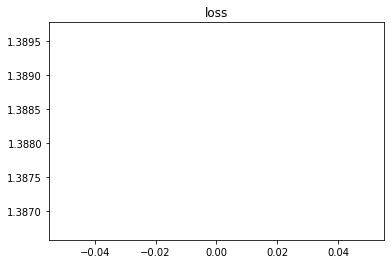

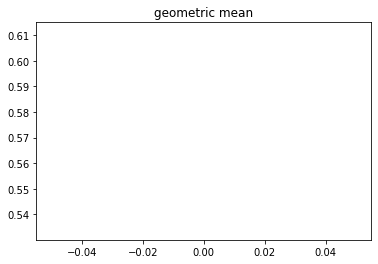

1_0.01_train_0.46530133_valid_0.44446725


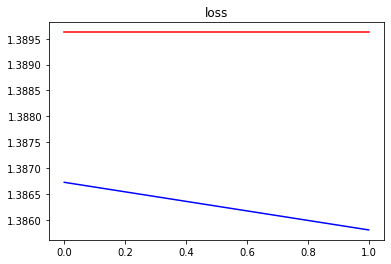

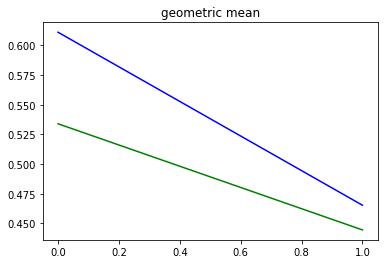

2_0.01_train_0.43356386_valid_0.4063451


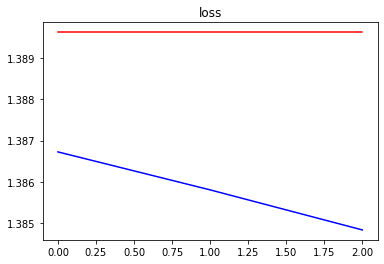

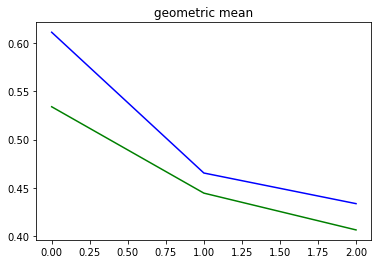

3_0.01_train_0.42576036_valid_0.3789661


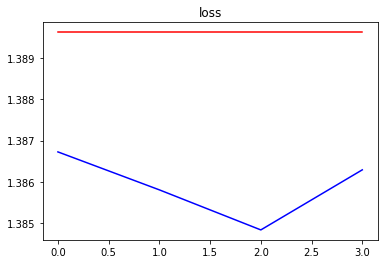

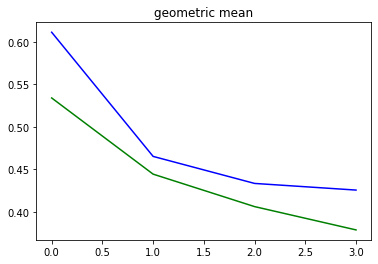

4_0.01_train_0.3586045_valid_0.31145272


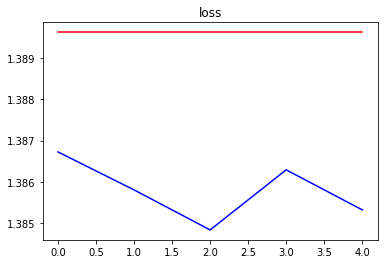

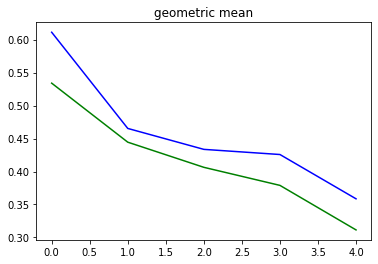

5_0.01_train_0.36021274_valid_0.2855737


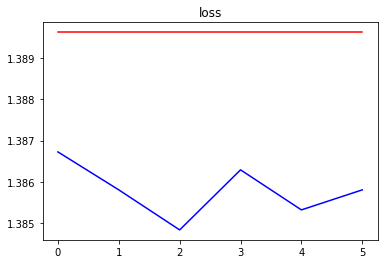

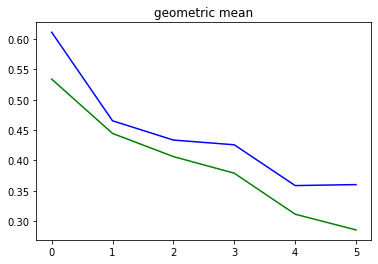

6_0.01_train_0.32186124_valid_0.33215404


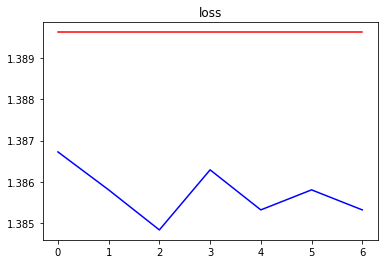

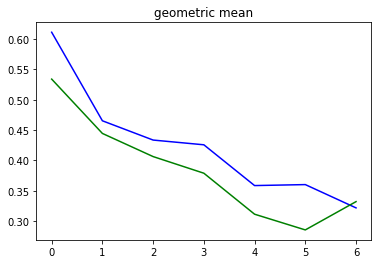

7_0.01_train_0.33660844_valid_0.35534072


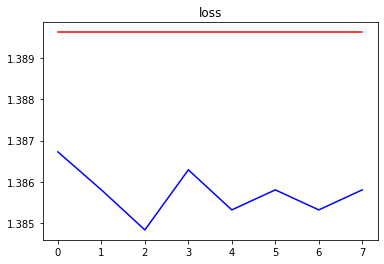

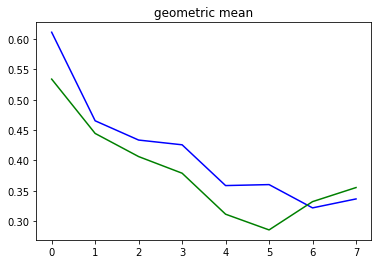

8_0.01_train_0.31651664_valid_0.2985228


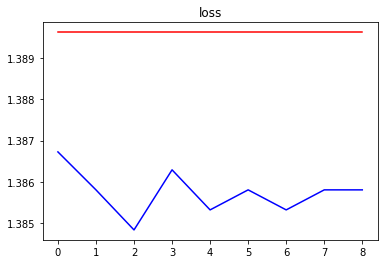

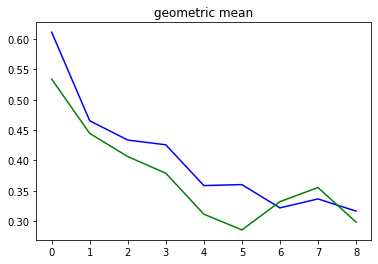

9_0.01_train_0.31222463_valid_0.29571065


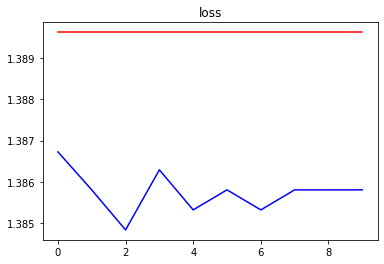

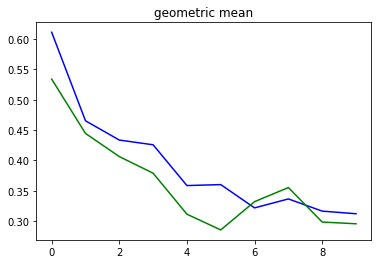

10_0.01_train_0.32379642_valid_0.32444656


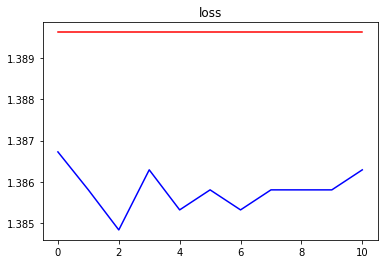

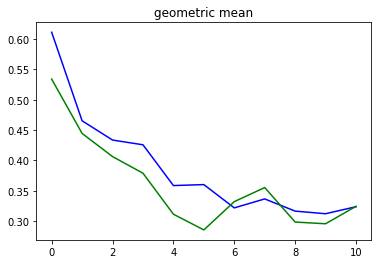

11_0.01_train_0.32612368_valid_0.28278834


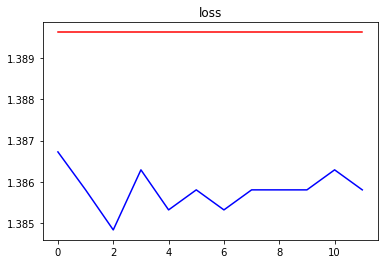

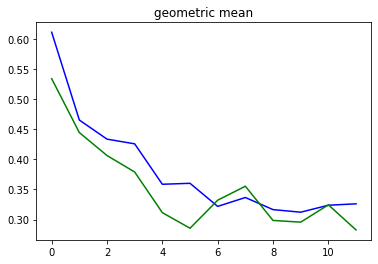

12_0.01_train_0.27291825_valid_0.25875556


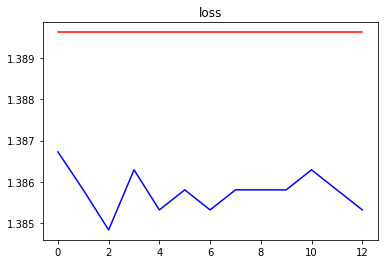

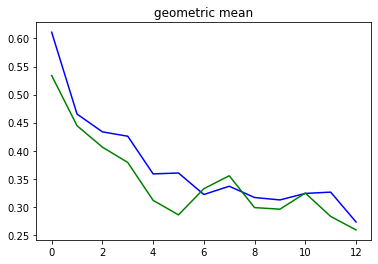

13_0.01_train_0.28866842_valid_0.29243588


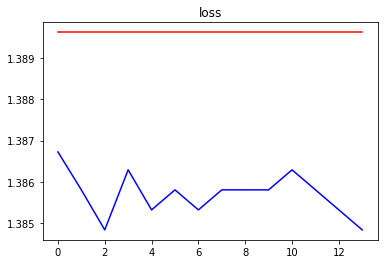

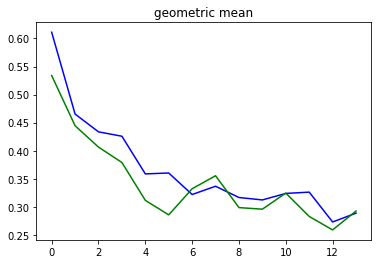

14_0.01_train_0.30089632_valid_0.29689687


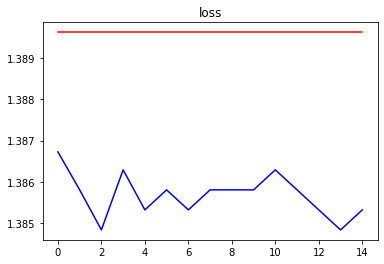

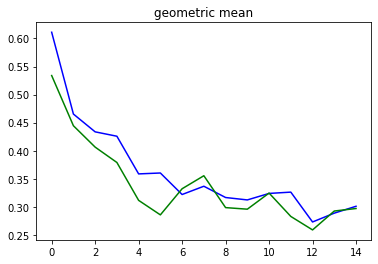

15_0.01_train_0.28489706_valid_0.2633239


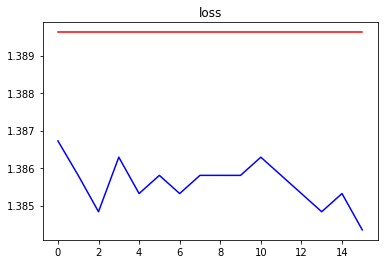

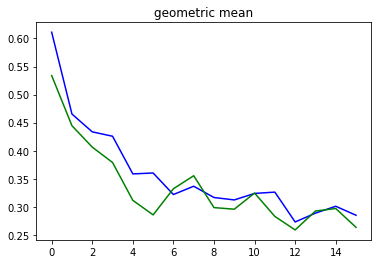

16_0.01_train_0.30335742_valid_0.24461119


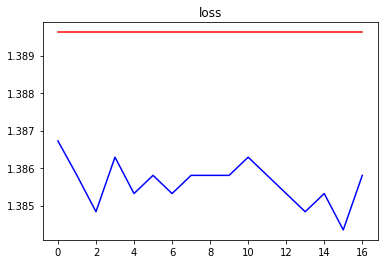

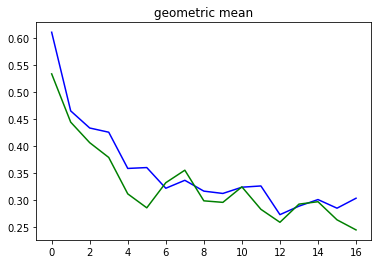

17_0.01_train_0.28396013_valid_0.23504326


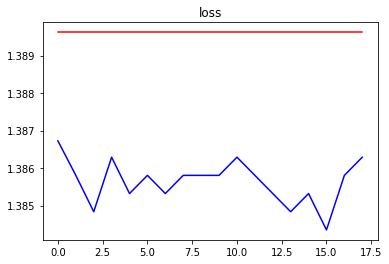

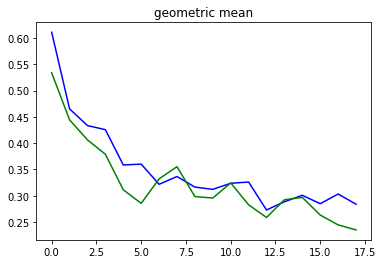

18_0.01_train_0.30682424_valid_0.30544442


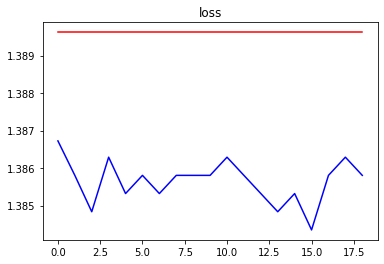

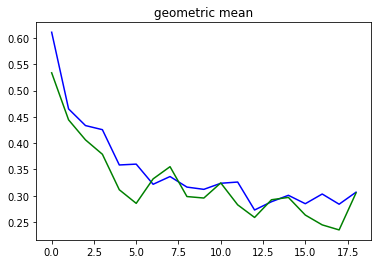

19_0.01_train_0.27826828_valid_0.26541


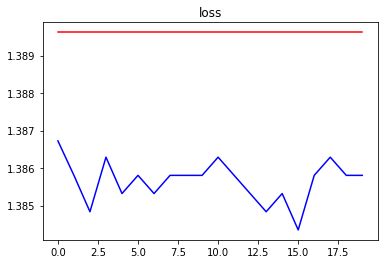

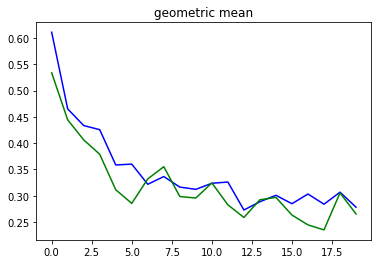

KeyboardInterrupt: ignored

In [65]:
import os
import numpy as np

import torch
from torch import optim
from torch.utils import data


def train(names_train,names_valid):
    
    device = torch.device("cuda:0")


    ## ceate weigths for our loss - pathologies are rare so they need larger weigths
    lbl_counts=np.load(Config.info_save_dir+os.sep+'lbl_counts.npy')
    num_of_sigs=np.load(Config.info_save_dir+os.sep+'num_of_sigs.npy')
    w_positive=num_of_sigs/lbl_counts
    w_negative=num_of_sigs/(num_of_sigs-lbl_counts)
    w_positive_tensor=torch.from_numpy(w_positive.astype(np.float32)).to(device)
    w_negative_tensor=torch.from_numpy(w_negative.astype(np.float32)).to(device)
    
    

    training_generator = Dataset(names_train, Config.DATA_TMP_PATH,'train')
    training_generator = data.DataLoader(training_generator,batch_size=Config.train_batch_size,num_workers= Config.train_num_workers, shuffle=True,drop_last=True,collate_fn=Dataset.collate_fn)

    validation_generator = Dataset(names_valid, Config.DATA_TMP_PATH,'valid')
    validation_generator = data.DataLoader(validation_generator,batch_size=Config.valid_batch_size, num_workers=Config.valid_num_workers, shuffle=False,drop_last=False,collate_fn=Dataset.collate_fn)



    model = Net_addition_grow(levels=Config.levels,lvl1_size=Config.lvl1_size,input_size=Config.input_size,output_size=Config.output_size,
                                  convs_in_layer=Config.convs_in_layer,init_conv=Config.init_conv,filter_size=Config.filter_size)

    model = model.to(device)

    ## create optimizer and learning rate scheduler to change learnng rate after 
    optimizer = optim.Adam(model.parameters(),lr =Config. init_lr ,betas= (0.9, 0.999),eps=1e-8,weight_decay=1e-8)
    scheduler=optim.lr_scheduler.StepLR(optimizer, Config.step_size, gamma=Config.gamma, last_epoch=-1)
    
    ## select loss function 
    loss_fcn=wce

    
    
    ## create empty log - object to save training results
    log=Log()
    
    for epoch in range(Config.max_epochs):
        
        #change model to training mode
        model.train()
        for pad_seqs,lens,lbls in training_generator:
            
            ## send data to graphic card
            pad_seqs,lens,lbls = pad_seqs.to(device),lens.to(device),lbls.to(device)

            ## aply model
            res,heatmap=model(pad_seqs,lens)
            
            ## calculate loss
            loss=loss_fcn(res,lbls,w_positive_tensor,w_negative_tensor)

            ## update model 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            ## save results
            log.save_tmp_log(lbls,res,loss)
      
        
        ## take mean of all batches -> get training performacne
        log.save_log_data_and_clear_tmp('train')  
            
            


        ## validation mode - "disable" batch norm 
        model.eval() 
        for pad_seqs,lens,lbls in validation_generator:

            pad_seqs,lens,lbls = pad_seqs.to(device),lens.to(device),lbls.to(device)

            res,heatmap=model(pad_seqs,lens)
            
            loss=loss_fcn(res,lbls,w_positive_tensor,w_negative_tensor)

            
            log.save_tmp_log(lbls,res,loss)
            
            
        log.save_log_data_and_clear_tmp('valid')     
        
                
        lr=get_lr(optimizer)
        
        info= str(epoch) + '_' + str(lr) + '_train_'  + str(log.trainig_beta_log[-1]) + '_valid_' + str(log.valid_beta_log[-1]) 
        print(info)
        
        model_name=Config.model_save_dir+ os.sep + Config.model_note + info  + '.pkl'
        log.save_log_model_name(model_name)
        model.save_log(log)
        model.save_config(Config)
        torch.save(model,model_name)
            
        ## plot loss and beta score
        model.plot_training()
        
        scheduler.step()
        

    return log



split=np.load(Config.info_save_dir + os.sep +'split.npy',allow_pickle=True).item()


try:
    os.mkdir(Config.best_models_dir)
except:
    pass

try:
    os.mkdir(Config.model_save_dir)
except:
    pass


log=train(split['train'],split['valid'])